In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *

In [2]:
movie_data = Path('/scratch/bpho/datasets/movies_001/')
model_path = Path('/scratch/bpho/models')

In [31]:
def get_src(scale_size):
    cropped_hr = movie_data/f'roi_hr_{scale_size}'
    cropped_lr = movie_data/f'roi_lr_{scale_size}'
    def map_to_hr(x):
        hr_name = x.relative_to(cropped_lr)
        return cropped_hr/hr_name
    src = (ImageImageList
            .from_folder(cropped_lr)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src


def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, scale=1, noise=0.05, tile_size=None):
    scale_size = scale * size
    if tile_size is None: tile_size = scale_size
    src = get_src(tile_size)
    tfms = get_transforms(flip_vert=True)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=scale_size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [32]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]


In [33]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [34]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [35]:
bs = 64
size = 128
data = get_data(bs, size, tile_size=256)
data

ImageDataBunch;

Train: LabelList
y: ImageItemList (6150 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /scratch/bpho/datasets/movies_001/roi_lr_256
x: ImageImageList (6150 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /scratch/bpho/datasets/movies_001/roi_lr_256;

Valid: LabelList
y: ImageItemList (600 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /scratch/bpho/datasets/movies_001/roi_lr_256
x: ImageImageList (600 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /scratch/bpho/datasets/movies_001/roi_lr_256;

Test: None

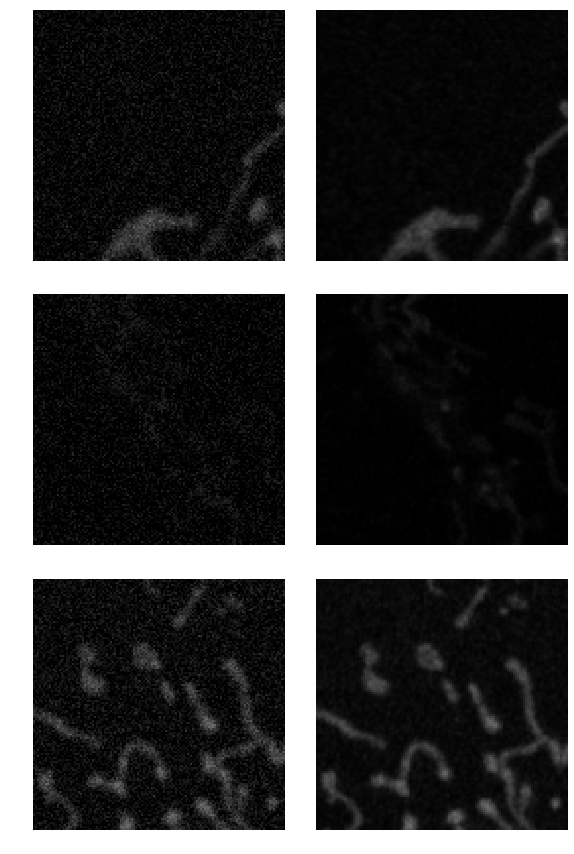

In [36]:
data.show_batch(3)

In [37]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

11992

In [38]:
# learn.lr_find()
# learn.recorder.plot()

In [39]:
lr = 1e-3

In [40]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.212631,2.350876,0.093290,0.174637,0.272013,0.042287,0.544763,1.195784,0.028102
2,1.729999,2.292047,0.100487,0.174337,0.256356,0.037032,0.583744,1.117938,0.022153
3,1.575885,1.724136,0.078126,0.129231,0.199673,0.027395,0.392037,0.880556,0.017117
4,1.501230,1.654076,0.077063,0.123793,0.181424,0.024278,0.413696,0.818576,0.015248
5,1.507847,1.791562,0.070002,0.139762,0.196324,0.026248,0.480199,0.863139,0.015890
6,1.498006,1.582555,0.048001,0.126586,0.178698,0.024106,0.415144,0.774636,0.015383
7,1.378372,1.652259,0.046945,0.132121,0.197260,0.027660,0.402759,0.828602,0.016912
8,1.276459,1.681275,0.041100,0.141473,0.210105,0.027936,0.422858,0.821835,0.015968
9,1.354657,1.982278,0.030057,0.152639,0.203165,0.024201,0.571526,0.986374,0.014316
10,1.214090,1.739038,0.032745,0.146734,0.189981,0.024141,0.524045,0.806921,0.014471


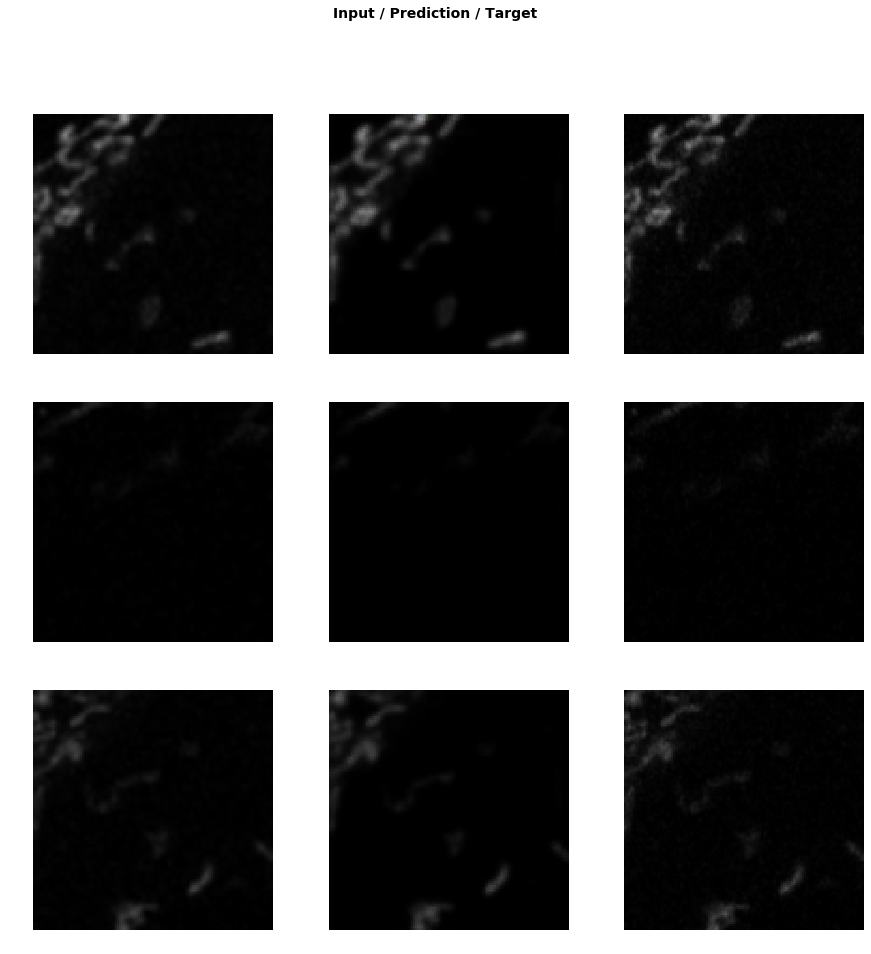

In [41]:
do_fit('movies_001.0', slice(lr*10))

In [42]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.151726,1.716661,0.033576,0.144208,0.187260,0.023562,0.511281,0.802742,0.014030
2,1.144442,1.798609,0.031351,0.146988,0.190477,0.023693,0.537717,0.854118,0.014265
3,1.141040,1.830060,0.032015,0.148465,0.192172,0.024011,0.550149,0.868656,0.014591
4,1.138005,1.749898,0.031013,0.146033,0.187453,0.023629,0.532192,0.815149,0.014429
5,1.133769,1.789844,0.027773,0.146673,0.190185,0.023955,0.538702,0.847751,0.014804
6,1.132686,1.874176,0.028245,0.150290,0.195313,0.024372,0.562839,0.898019,0.015098
7,1.125720,1.936230,0.027415,0.150319,0.199153,0.024645,0.567638,0.951627,0.015433
8,1.126185,1.732269,0.028673,0.141849,0.185027,0.022988,0.508749,0.831012,0.013972
9,1.129611,1.675746,0.029514,0.144028,0.187828,0.024325,0.493091,0.782283,0.014677
10,1.112188,1.780989,0.026458,0.147339,0.191298,0.024768,0.532482,0.842742,0.015900


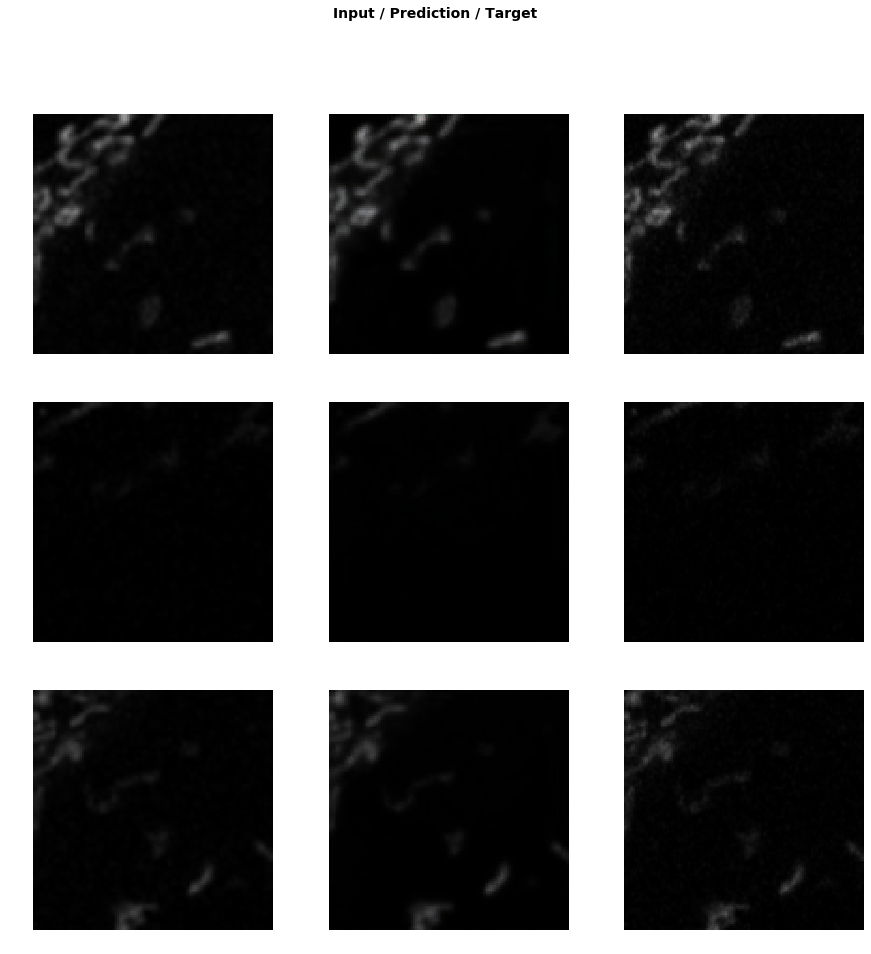

In [43]:
do_fit('movies_001.1', slice(1e-5,lr))

In [44]:
#learn.load('movies_001.1')

In [45]:
!ls /scratch/bpho/models

movies_001.0.pth  movies_rddb_001.0.pth  tmp.pth
movies_001.1.pth  movies_rddb_001.1.pth


In [46]:
movie_files = list((movie_data/'test').glob('*.czi'))

In [47]:
fn = movie_files[0]

In [48]:
with czifile.CziFile(fn) as czi_f:
    proc_axes, proc_shape = get_czi_shape_info(czi_f)
    channels = proc_shape['C']
    depths = proc_shape['Z']
    times = proc_shape['T']
    x,y = proc_shape['X'], proc_shape['Y']
    data = czi_f.asarray()
    preds = []
    origs = []
    idx = build_index(proc_axes, {'T': 0, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
    img = data[idx].astype(np.float32)
    img /= (img.max() * 1.5)

In [49]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [50]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.5
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)

        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)


In [51]:
bs=1
size=1024
scale = 4

data = get_data(bs, size, scale, noise=0.03, tile_size=128)

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()
learn = learn.load('movies_001.1')

for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif'
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )